# Smart Charging Using Reinforcement Learning

In [112]:
import numpy as np
from gym import Env
from gym.spaces import Box, Discrete
import random
import math
from keras.models import Sequential
from keras.layers import Dense, Flatten
from tensorflow.keras.optimizers.legacy import Adam

from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory
import matplotlib.pyplot as plt 
import pandas as pd
import tensorflow as tf
#%matplotlib inline

In [138]:
from tensorflow.keras.optimizers import SGD

## Electric Vehicle Charging Environment
We start by creating the environment for simulating electric vehicle (EV) charging using the OpenAI Gym framework. The environment defines a Markov decision process, including states, actions and a reward function with different charging rates and time-dependent energy prices.

## Electric Vehicle Charging Environment

This code defines a custom environment for simulating electric vehicle (EV) charging using the OpenAI Gym framework. The environment models the charging process of an EV with different charging rates and time-dependent energy prices.

### Key Components

- `action_space`: The environment offers four charging actions: no charge, low, medium, and high charging.

- `battery_limit`: Represents the EV's battery capacity, assumed to be 100 kWh.

- `battery_level`: Initialized to the battery's full capacity at the start.

- `observation_space`: A state consists of the battery level and the current time interval.

- `current_time_index`: Tracks the time interval (0-7) for charging intervals.

- `time_coefficients`: Coefficients representing volatile energy prices from 2pm to 4pm ranging from 47$/MWh to 50$/MWh or 0.94 to 1. (Source: https://www.researchgate.net/profile/Torjus-Bolkesjo/publication/310021998/figure/fig3/AS:431952714047493@1479996960479/Hourly-intra-day-variation-of-the-electricity-price-for-Germany-in-MWh-and-the.png)

- `charging_rates`: Charging rates for different actions (0, 1.75, 3.5, 5.5 kWh).

### Functions

- `step(action)`: Simulates one time step in the environment. The agent's action determines the charging rate, and the environment updates the battery level, calculates rewards based on energy prices, and applies penalties for insufficient battery levels.

- `reset()`: Resets the environment to the initial state, including battery level and time.

### Objective

The agent's objective is to make charging decisions that minimize costs, considering time of day and charging rate. By interacting with this environment, the agent can learn strategies to optimize the charging process and manage the EV's battery effectively.


In [113]:
class EVChargingEnvironment(Env):
    def __init__(self):
        self.action_space = Discrete(4) # Action space contains 4 actions: zero, low, medium, high charging
        self.battery_limit = 58 # Assumption: 58 kWh (Netto) battery capacity (VW ID.3 Pro)
        self.battery_level = self.battery_limit # Assumption: Battery fully charged at initialization

        # A state in the environment consists of battery level (0-100 kWh) and time interval (0-7) 
        self.observation_space = np.array([Box(low=np.array([0]), high = np.array([self.battery_limit])), Box(low=np.array([0]), high = np.array([8]))])

        # Initialize first state
        self.current_time_index = 0
        self.state = np.array([self.battery_level, self.current_time_index]) 

        # Electricity price distribution: Starting at $50/MWh, decreasing to $47/MWh after 4 intervals, then increasing back to $50/MWh
        self.time_coefficients = [1.0, 0.98, 0.96, 0.94, 0.94, 0.96, 0.98, 1.0]

        # Charging rates in range 0, 7, 14, 22 kWh divided by 4 (because we charge only 15 minutes)
        self.charging_rates = [0, 1.75, 3.5, 5.5]

    def step(self, action):

        # Set time attribute of state to 
        self.state[1] = self.current_time_index

        # Get current time coefficient and charging rate
        time_coefficient = self.time_coefficients[self.current_time_index]
        charging_rate = self.charging_rates[action]
        
        # If the charging rate exceeds the limit, we only charge the amount of difference
        if self.battery_level + charging_rate > self.battery_limit:
            charging_rate = self.battery_limit - self.battery_level
        
        # Increase battery level
        self.battery_level += charging_rate
        self.state[0] = self.battery_level
        
        # Reward function
        reward = time_coefficient * math.exp(charging_rate) * (-1)

        # Assumption: Reward should be Zero for Zero charging
        if charging_rate == 0:
            reward = 0

        # Update time index
        self.current_time_index = (self.current_time_index + 1) % 8

        # Check if simulation is complete
        done = self.current_time_index == 0

        if done:

            # Set energy demand
            energy_demand = np.random.normal(30, 5)

            # Set new battery level
            self.battery_level = self.battery_level - energy_demand
            
            # Set penalty if battery level is too low for energy demand
            if self.battery_level < 0:
                # We set a very high penalty of 10,000 because of the cost function resulting in high costs
                reward -= 10000.0
                self.battery_level = 0 # Set Battery Level to Zero
                self.state[0] = self.battery_level

        # Setting the placeholder for info
        info = {}
        
        return self.state, reward, done, info

    def reset(self):

        # Set current time index to Zero
        self.current_time_index = 0

        # Initialize first state of episode
        # We use the current battery level resulting from the last episode (after demand subtraction)
        self.state = np.array([self.battery_level, self.current_time_index])

        return self.state

In [114]:
env = EVChargingEnvironment()

/home/lukas/.local/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


### Environment Exploration

In [115]:
episodes = 10

for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0

    while not done:
        action = env.action_space.sample()
        n_state, reward, done, info = env.step(action)
        score += reward

In [116]:
episodes = 10

for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0

    if episode % 10 == 0:
        print(f"Episode {episode}\nInitial State: {state}")

    while not done:
        action = env.action_space.sample()
        n_state, reward, done, info = env.step(action)
        score += reward

        if episode % 10 == 0:
            print(f"Action: {action} | New State: {n_state} | Reward: {reward} | Done: {done}")
    
    if episode % 10 == 0:
        print(f"Episode {episode} - Score: {score}\n{'*' * 50}")


Episode 10
Initial State: [0 0]
Action: 2 | New State: [3 0] | Reward: -33.11545195869231 | Done: False
Action: 0 | New State: [3 1] | Reward: 0 | Done: False
Action: 3 | New State: [9 2] | Reward: -234.90425497365155 | Done: False
Action: 2 | New State: [12  3] | Reward: -31.128524841170773 | Done: False
Action: 0 | New State: [12  4] | Reward: 0 | Done: False
Action: 2 | New State: [16  5] | Reward: -31.790833880344618 | Done: False
Action: 3 | New State: [21  6] | Reward: -239.79809361893598 | Done: False
Action: 2 | New State: [0 7] | Reward: -10033.115451958693 | Done: True
Episode 10 - Score: -10603.852611231488
**************************************************


We can see how the agent performs actions in the environment and gets the rewards. Without a learnt policy, the agent is not able to meet the energy demand. Therefore, the rewards suffer from high penalties.

## Deep Q-Network using Keras

In the next step we create a deep Q-Network for approximating the Q-values in our environment. With Q-Learning we are able to learn about the greedy policy, while using a different behaviour policy for acting in the environment. The behaviour policy is usually an e-greedy policy, that selects the greedy action with probability 1 - e and a random action with probability e to ensure good coverage of the state-action space.

In [117]:
# Get shpaes of states and actions of our environment
states = env.observation_space.shape
actions = env.action_space.n
print("Actions: " + str(actions) + " | States: " + str(states))

Actions: 4 | States: (2,)


In [118]:
# build the model for Q- and target network. We define one flatten layer and three dense layers with ReLU activation function
def build_model(states, actions):
    model = Sequential()   
    model.add(Flatten(input_shape=(1,2)))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

In [119]:
# Instantiate model
model = build_model(states, actions)
model.summary()

**build_agent**: In this function, we define our policy using the **BoltzmannQPolicy**. This policy constructs a probability distribution based on the Q-values and randomly selects an action according to this distribution. The DQNAgent uses Sequential Memory to store various states, actions and rewards.

In [122]:
def build_agent(model, actions):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=50000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy, 
                  nb_actions=actions, nb_steps_warmup=10000, target_model_update=1e-2)
    return dqn

Now we can create an agent that learns a policy through minimizing the loss between the target Q-network (actual Q-values) and the Q-network (approximated Q-values). We employ the Adam optimizer with a learning rate of 0.001 and use mean squared error (MSE) as the loss function. The agent is trained for 60,000 steps.

In [160]:
dqn = build_agent(model, actions)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])
training_results = dqn.fit(env, nb_steps=100000, visualize=False, verbose=1)

/home/lukas/.local/lib/python3.10/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2023-08-14 10:41:38.130227: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_16_7/bias/Assign' id:6708 op device:{requested: '', assigned: ''} def:{{{node dense_16_7/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_16_7/bias, dense_16_7/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Training for 100000 steps ...
Interval 1 (0 steps performed)


/home/lukas/.local/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-08-14 10:41:38.646735: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_17/BiasAdd' id:4189 op device:{requested: '', assigned: ''} def:{{{node dense_17/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_17/MatMul, dense_17/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-08-14 10:41:38.831387: W tensorflow/c/c_api.cc:304] Operation '{name:'total_51/Assign' id:6890 op device:{requested: '', assigned: ''} def:{{{node total_51/Assign}} = AssignVariableOp[_has_manual_con

10000/10000 [==============================] - 26s 3ms/step - reward: -1088.8753
1250 episodes - episode_reward: -8711.003 [-11419.213, -127.826]

Interval 2 (10000 steps performed)
    1/10000 [..............................] - ETA: 33s - reward: -244.6919

2023-08-14 10:42:05.108331: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_17_7/BiasAdd' id:6737 op device:{requested: '', assigned: ''} def:{{{node dense_17_7/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_17_7/MatMul, dense_17_7/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-08-14 10:42:05.538801: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_56/AddN' id:6991 op device:{requested: '', assigned: ''} def:{{{node loss_56/AddN}} = AddN[N=2, T=DT_FLOAT, _has_manual_control_dependencies=true](loss_56/mul, loss_56/mul_1)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-08-

10000/10000 [==============================] - 160s 16ms/step - reward: -980.3658
1250 episodes - episode_reward: -7842.927 [-11433.895, -118.593] - loss: 602834.370 - mae: 3680.083 - mean_q: -3932.900

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 168s 17ms/step - reward: -978.7174
1250 episodes - episode_reward: -7829.740 [-11231.959, -86.342] - loss: 607183.500 - mae: 3795.903 - mean_q: -4097.817

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 170s 17ms/step - reward: -1067.2898
1250 episodes - episode_reward: -8538.318 [-11433.895, -113.933] - loss: 618792.688 - mae: 3683.406 - mean_q: -3933.358

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 158s 16ms/step - reward: -1090.8036
1250 episodes - episode_reward: -8726.429 [-11455.898, -172.537] - loss: 628287.562 - mae: 3746.326 - mean_q: -4014.556

Interval 6 (50000 steps performed)
10000/10000 [==============================] - 

### Loss and Metrics Plotting

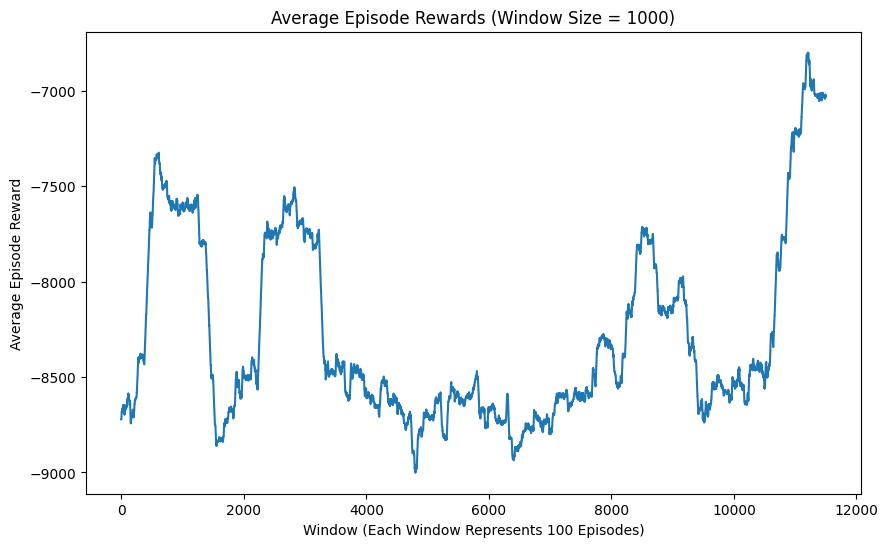

In [163]:
episode_rewards = training_results.history['episode_reward']

window_size = 1000
averages = [np.mean(episode_rewards[i:i+window_size]) for i in range(0, len(episode_rewards) - window_size + 1)]

plt.figure(figsize=(10, 6))
plt.plot(averages)
plt.title(f'Average Episode Rewards (Window Size = {window_size})')
plt.xlabel('Window (Each Window Represents 100 Episodes)')
plt.ylabel('Average Episode Reward')
plt.show()

In [162]:
results = dqn.test(env, nb_episodes=10, visualize=False)
results.history['episode_reward']

Testing for 10 episodes ...
Episode 1: reward: -1898.809, steps: 8
Episode 2: reward: -1077.893, steps: 8
Episode 3: reward: -1492.583, steps: 8
Episode 4: reward: -256.976, steps: 8
Episode 5: reward: -256.976, steps: 8
Episode 6: reward: -256.976, steps: 8
Episode 7: reward: -256.976, steps: 8
Episode 8: reward: -256.976, steps: 8
Episode 9: reward: -230.162, steps: 8
Episode 10: reward: -256.976, steps: 8


[-1898.8093943703502,
 -1077.8926507849012,
 -1492.5825521837364,
 -256.9759071994523,
 -256.9759071994523,
 -256.9759071994523,
 -256.9759071994523,
 -256.9759071994523,
 -230.16227490241948,
 -256.9759071994523]

### Testing EV Charging Environment
After training our policy, we now can test it and see the actions taken by the learnt policy.

In [145]:
num_episodes = 1000

for episode in range(num_episodes):
    learned_policy = []
    scores = 0
    state = env.reset()
    done = False
    battery_level = state[0]
    if episode % 100 == 0:
        print(f"Episode {episode + 1}: Initial battery level: {battery_level}") 

    while not done:
        state = np.expand_dims(state, axis=0)
        q_values = dqn.compute_q_values(state)  # Get Q-values from the DQN
        learned_action = np.argmax(q_values)  # Choose action with highest Q-value
        learned_policy.append(learned_action)
        state, reward, done, _ = env.step(learned_action)
        scores += reward
    if episode % 100 == 0:
        print(f"Episode {episode + 1}: Learned Policy: {learned_policy}")
        print(f"Episode {episode + 1}: Score: {scores}")

Episode 1: Initial battery level: 19.496086354570252


/home/lukas/.local/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-08-14 10:34:58.559820: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_17/BiasAdd' id:4189 op device:{requested: '', assigned: ''} def:{{{node dense_17/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_17/MatMul, dense_17/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Episode 1: Learned Policy: [3, 2, 2, 2, 2, 2, 2, 3]
Episode 1: Score: -680.1288678105085
Episode 101: Initial battery level: 30.03553536171595
Episode 101: Learned Policy: [1, 1, 1, 1, 2, 2, 2, 2]
Episode 101: Score: -150.81581198262842
Episode 201: Initial battery level: 22.127482035437424
Episode 201: Learned Policy: [3, 1, 2, 2, 2, 2, 2, 2]
Episode 201: Score: -441.7387552079475
Episode 301: Initial battery level: 19.129428843048824
Episode 301: Learned Policy: [3, 2, 2, 2, 2, 2, 3, 2]
Episode 301: Score: -675.897338204398
Episode 401: Initial battery level: 20.29632886380765
Episode 401: Learned Policy: [3, 2, 2, 2, 2, 2, 2, 2]
Episode 401: Score: -468.5523875049804
Episode 501: Initial battery level: 22.844819412239165
Episode 501: Learned Policy: [2, 2, 2, 2, 2, 2, 2, 2]
Episode 501: Score: -256.9759071994523
Episode 601: Initial battery level: 14.130715249168524
Episode 601: Learned Policy: [3, 3, 3, 2, 3, 2, 2, 2]
Episode 601: Score: -1077.8926507849012
Episode 701: Initial bat

From these results we can obtain that the optimal charging policy is to avoid charging in the first two intervals. We know from the energy price market, that energy prices are high at this time. The agent uses the lower energy prices in the middle of the time period (around 3pm). The agent has also learnt to charge with a higher rate when the initial battery level is low. Therefore, it avoids that the vehicle runs out of energy.

A possible reason for the agent to charge with a high charging rate at the end of the episode is to avoid the penalty for running out of energy. Another reason could be the discount factor used in the calculation of the target Q-values. The discount factor makes the agent prioritize immediate rewards over delayed rewards.